
# Predicting the Price of Used Cars Using Machine Learning Algorithms
<font color = 'Blue'> 
Names: Shin Le, Jeongyeon Kim, Benjamin Horvath, Nico Reategui, Paul Giglio


Proposal: https://docs.google.com/document/d/1zhQrkWmJjjMU6wIfBC78MygGzp-XUrkaUOWALfyAL9Q/edit

Dataset: https://www.kaggle.com/datasets/wspirat/germany-used-cars-dataset-2023/data

<a id="0"></a> <br>
<font color = 'Blue'> 
# Table of Contents

1. [About Dataset](#1)
1. [Importing Libraries](#2)
1. [Functions Implementation](#3)
1. [Loading Data](#4)
1. [Data Preprocessing](#5)
1. [Exploratory Data Analysis (EDA)](#6)
1. [Data Splitting](#7)
1. [Models Evaluations and Predictions](#8)
   1. [*Full Model* with *Linear Regression*](#81)
   1. [Using Sequential Feature Selection for the *Linear Regression*](#82)
   1. [*Decision Tree*](#83)
   1. [*A Pruned Tree*](#84)
   1. [Ensemble Method: *Random Forest Regression*](#85)
   1. [Ensemble Method: *Gradient Boosting Regression*](#86)
   1. [*Support Vector Machine* (SVM)](#87)


<a id="1"></a>
<font color = 'blue'> 
## **1. About Dataset**

<a id="2"></a>
<font color = 'blue'> 
## **2. Importing Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # Corrected import
%matplotlib inline  # Ensures that Matplotlib plots are displayed inline

import statsmodels.api as sm


#preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder 




UsageError: unrecognized arguments: # Ensures that Matplotlib plots are displayed inline


<a id="3"></a>
<font color = 'blue'> 
## **3. Functions Implementation**


<a id="4"></a>
<font color = 'blue'> 
## **4. Loading Data**

In [4]:

# Define the URL of the CSV file on GitHub
csv_url = "https://raw.githubusercontent.com/syl21b/Car-Price-Prediction/main/germanycars.csv?token=GHSAT0AAAAAACIQMGDULPNRHLQ2KWG4IPR4ZJ35N5Q"

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_url)

# Now you have the data in the 'df' DataFrame

<a id="5"></a>
<font color = 'blue'> 
## **5. Data Preprocessing**

In [5]:
df

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300,148,201,Manual,Petrol,10.9,260.0,160500.0,2.0 V6 TB
1,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900,110,150,Manual,Petrol,9.5,225.0,189500.0,2.0 16V Twin Spark L
2,alfa-romeo,Alfa Romeo 164,red,11/1996,1996,17950,132,179,Manual,Petrol,7.2,NaN,96127.0,"3.0i Super V6, absoluter Topzustand !"
3,alfa-romeo,Alfa Romeo Spider,red,04/1996,1996,7900,110,150,Manual,Petrol,9.5,225.0,47307.0,2.0 16V Twin Spark
4,alfa-romeo,Alfa Romeo 145,red,12/1996,1996,3500,110,150,Manual,Petrol,8.8,210.0,230000.0,Quadrifoglio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224986,volvo,Volvo XC60,silver,05/2023,2023,55400,145,197,Automatic,Diesel,5.6,142.0,5000.0,B4 Autom. Plus Dark Keyless-Start/Klima/LED/BC
224987,volvo,Volvo XC60,silver,03/2023,2023,54500,145,197,Automatic,Diesel,5.6,142.0,5900.0,B4 Autom. Plus Dark Sitzhzg.
224988,volvo,Volvo XC90,white,03/2023,2023,89690,173,235,Automatic,Diesel,7.6,202.0,4900.0,B5 AWD Diesel Ultimate Dark 7-Sitzer Massage F...
224989,volvo,Volvo V60,white,05/2023,2023,61521,145,197,Automatic,Diesel,4.7,125.0,1531.0,"B4 D Plus Dark 145 kW, 5-türig (Diesel)"


In [6]:
df.info() #shows a summary of our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224991 entries, 0 to 224990
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     224991 non-null  object 
 1   model                     224991 non-null  object 
 2   color                     224991 non-null  object 
 3   registration_date         224991 non-null  object 
 4   year                      224991 non-null  int64  
 5   price_in_euro             224991 non-null  int64  
 6   power_kw                  224991 non-null  int64  
 7   power_ps                  224991 non-null  int64  
 8   transmission_type         224991 non-null  object 
 9   fuel_type                 224991 non-null  object 
 10  fuel_consumption_l_100km  224991 non-null  float64
 11  fuel_consumption_g_km     198951 non-null  float64
 12  mileage_in_km             224991 non-null  float64
 13  offer_description         224991 non-null  o

* Check and drop **Null** values

In [7]:
df.isnull().sum()

brand                           0
model                           0
color                           0
registration_date               0
year                            0
price_in_euro                   0
power_kw                        0
power_ps                        0
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km        0
fuel_consumption_g_km       26040
mileage_in_km                   0
offer_description               0
dtype: int64

There is null value in **fuel_consumption_g_km** column. So, we need to drop these before using it

In [8]:
df=df.dropna().reset_index(drop=True)

* Check and drop duplicates:

In [9]:
df=df.drop_duplicates()

The data set after cleaning up

In [10]:
df

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300,148,201,Manual,Petrol,10.9,260.0,160500.0,2.0 V6 TB
1,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900,110,150,Manual,Petrol,9.5,225.0,189500.0,2.0 16V Twin Spark L
2,alfa-romeo,Alfa Romeo Spider,red,04/1996,1996,7900,110,150,Manual,Petrol,9.5,225.0,47307.0,2.0 16V Twin Spark
3,alfa-romeo,Alfa Romeo 145,red,12/1996,1996,3500,110,150,Manual,Petrol,8.8,210.0,230000.0,Quadrifoglio
4,alfa-romeo,Alfa Romeo 164,black,07/1996,1996,5500,132,179,Manual,Petrol,13.4,320.0,168000.0,(3.0) V6 Super
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198946,volvo,Volvo XC60,silver,04/2023,2023,81350,228,310,Automatic,Hybrid,7.4,167.0,60.0,"XC 60 T8 AWD Ultimate Dark PHEV NAVI,AHK,STHZ,..."
198947,volvo,Volvo XC60,silver,05/2023,2023,55400,145,197,Automatic,Diesel,5.6,142.0,5000.0,B4 Autom. Plus Dark Keyless-Start/Klima/LED/BC
198948,volvo,Volvo XC60,silver,03/2023,2023,54500,145,197,Automatic,Diesel,5.6,142.0,5900.0,B4 Autom. Plus Dark Sitzhzg.
198949,volvo,Volvo XC90,white,03/2023,2023,89690,173,235,Automatic,Diesel,7.6,202.0,4900.0,B5 AWD Diesel Ultimate Dark 7-Sitzer Massage F...


* Counting the data for each feature:

In [11]:
for feature in df.columns.tolist():
    print(f"{df[feature].value_counts()}, \n")

volkswagen       25821
mercedes-benz    20829
audi             16107
opel             15982
ford             14819
bmw              14222
skoda            11417
seat              9664
toyota            6473
renault           6234
hyundai           5151
kia               4570
peugeot           4547
mazda             3656
fiat              3614
volvo             3444
mini              3408
porsche           3084
nissan            2961
citroen           2888
dacia             2625
land-rover        2601
jeep              1341
alfa-romeo        1132
jaguar            1118
smart             1002
mitsubishi         681
honda              629
maserati           501
bentley            373
ferrari            293
ssangyong          276
lamborghini        248
dodge              246
aston-martin       203
daihatsu           145
lada               145
saab               141
cadillac           105
chevrolet           92
isuzu               91
lancia              78
infiniti            75
daewoo     

We can observe the presence of outliers, and the data spans a wide range.

<a id="6"></a>
<font color = 'blue'> 
## **6. Exploratory Data Analysis (EDA)**

### Dectecting outliers
* For numerical columns

In [12]:

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#numerical_cols.remove('Senior Citizen')
num_columns=df[numerical_cols]

Q1 = num_columns[numerical_cols].quantile(0.25)
Q3 = num_columns[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers and create a boolean mask
outliers_mask = (num_columns[numerical_cols] < lower_bound) | (num_columns[numerical_cols] > upper_bound)

# Drop the rows containing outliers
num_columns = num_columns[~outliers_mask]

This is the new numerical columns after deleted the outliers

In [16]:
new_num_columns= num_columns.dropna() #drop the rows which are contain NAN 
new_num_columns

,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
79,2005.0,5900.0,122.0,166.0,9.2,220.0,203997.0
81,2005.0,2000.0,122.0,166.0,8.7,207.0,219000.0
83,2005.0,3199.0,77.0,105.0,8.2,196.0,123518.0
84,2005.0,10800.0,122.0,166.0,8.7,207.0,92000.0
85,2005.0,5900.0,103.0,140.0,8.5,202.0,132250.0
...,...,...,...,...,...,...,...
198937,2023.0,50000.0,145.0,197.0,6.3,143.0,6047.0
198940,2023.0,37900.0,120.0,163.0,6.6,166.0,2145.0
198943,2023.0,37995.0,120.0,163.0,6.7,152.0,2100.0
198947,2023.0,55400.0,145.0,197.0,5.6,142.0,5000.0


This method is just applied for numercal columns. There is no specific way to detect outlier for categorical columns. We can plot the Frequency vs Price for each categorical columns and decide the outliers depend on the frequency.

* For categorical columns, we need to plot it vs Price to see the pattern

In [14]:
cat_columns=['brand','transmission_type','fuel_type' ] #these are the columns that wee need to plot se dectect the outliers

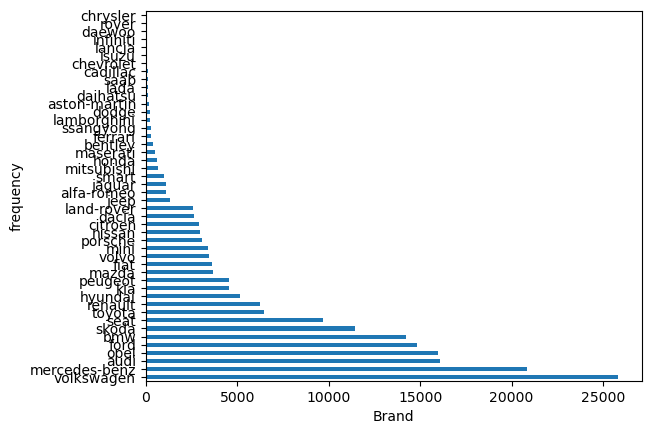

In [32]:
fig, ax = plt.subplots()

df['brand'].value_counts().plot(ax=ax, kind='barh', xlabel='Brand', ylabel='frequency')

plt.show()

* Plot Average Price vs Years


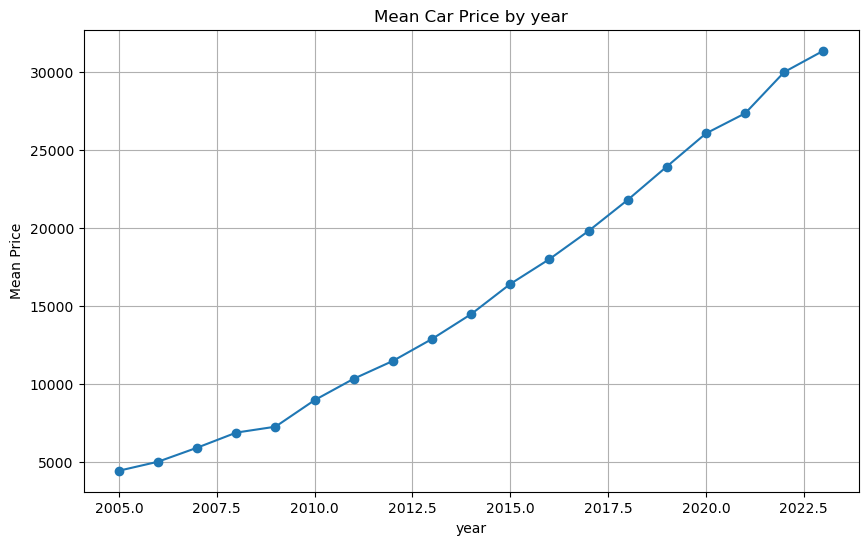

In [15]:
mean_prices_by_year = new_num_columns.groupby('year')['price_in_euro'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(mean_prices_by_year['year'], mean_prices_by_year['price_in_euro'], marker='o', linestyle='-')
plt.title('Mean Car Price by year')
plt.xlabel('year')
plt.ylabel('Mean Price')
plt.grid(True)
plt.show()